# Decision Trees for handwritten digit recognition

This notebook demonstrates learning a Decision Tree using Spark's distributed implementation. It gives the reader a better understanding of some critical hyperparameters for the tree learning algorithm, using examples to demonstrate how tuning the hyperparameters can improve accuracy.

- Background: To learn more about Decision Trees, check out the resources at the end of this notebook. The visual description of ML and Decision Trees provides nice intuition helpful to understand this notebook, and Wikipedia gives lots of details.
- Data: We use the classic MNIST handwritten digit recognition dataset.
- Goal: Our goal for our data is to learn how to recognize digits (0 - 9) from images of handwriting. However, we will focus on understanding trees, not on this particular learning problem.
- Takeaways: Decision Trees take several hyperparameters which can affect the accuracy of the learned model. There is no one "best" setting for these for all datasets. To get the optimal accuracy, we need to tune these hyperparameters based on our data.

In [1]:
#!rm -rf data

In [2]:
import mlflow.pyfunc
import mlflow.spark
import mlflow
from mlflow.tracking import MlflowClient
 
mlflow.set_tracking_uri("http://host.docker.internal:5000")
client = MlflowClient("http://host.docker.internal:5000")

In [3]:
from pyspark import SparkFiles
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('handwritten digit recognition').getOrCreate()

In [4]:
#!mkdir data ;wget https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/train.csv  -O data/train.csv
#!wget https://raw.githubusercontent.com/sbussmann/kaggle-mnist/master/Data/test.csv  -O data/test.csv

In [5]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
data = spark.read.format("csv").option("header","true").option("inferSchema","true").load('./data/train.csv')
data_test = spark.read.format("csv").option("inferSchema","true").load('./data/test.csv', schema = data.schema[1:])

print(f"We have ${data.count()} in training images and ${data_test.count()} in test images   ")

We have $42000 in training images and $28001 in test images   


In [6]:

windowSpec  = Window.partitionBy("label")
windowSpecAgg = windowSpec.orderBy('rnd')
data = data.withColumn('rnd',rand())\
    .withColumn("rn_", row_number().over(windowSpecAgg)) \
    .withColumn("test", when(col("rn_")/max(col('rn_')).over(windowSpec)*lit(100) >= 90, 0).otherwise(1)) \
    .drop('rnd','rn_') 
training = data.filter('test==1').drop('test')
validation = data.filter('test==0').drop('test')
print(f"We have ${training.count()} training images and ${validation.count()} validation images .")

We have $37794 training images and $4206 validation images .


In [7]:
training.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3718|
|    1| 4215|
|    2| 3759|
|    3| 3915|
|    4| 3664|
|    5| 3415|
|    6| 3723|
|    7| 3960|
|    8| 3656|
|    9| 3769|
+-----+-----+



In [8]:
validation.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  414|
|    1|  469|
|    2|  418|
|    3|  436|
|    4|  408|
|    5|  380|
|    6|  414|
|    7|  441|
|    8|  407|
|    9|  419|
+-----+-----+



## Train a Decision Tree

In [9]:
from  pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.feature import StringIndexer,VectorAssembler
from pyspark.ml import Pipeline

In [10]:
# StringIndexer: Read input column "label" (digits) and annotate them as categorical values.
vectorizer = VectorAssembler(inputCols=training.columns[1:], outputCol="features", handleInvalid='skip')
indexer = StringIndexer(inputCol ="label",outputCol="indexedLabel")

# DecisionTreeClassifier: Learn to predict column "indexedLabel" using the "features" column.
dtc =  DecisionTreeClassifier( featuresCol="features",labelCol="indexedLabel")
stages = [indexer,vectorizer, dtc]
# Chain indexer + dtc together into a single ML Pipeline.
pipeline = Pipeline().setStages(stages)

In [11]:
model = pipeline.fit(training)

In [12]:
tree = model.stages[-1]
display(tree)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_0a0822dbae58, depth=5, numNodes=59, numClasses=10, numFeatures=784

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", 
                                               predictionCol="prediction", 
                                               metricName="accuracy")

In [14]:
val_pred = model.transform(validation)
val_pred.select("label","indexedLabel","features","prediction").show(2)
evaluator.evaluate(val_pred)

+-----+------------+--------------------+----------+
|label|indexedLabel|            features|prediction|
+-----+------------+--------------------+----------+
|    1|         0.0|(784,[152,153,154...|       0.0|
|    1|         0.0|(784,[125,126,127...|       0.0|
+-----+------------+--------------------+----------+
only showing top 2 rows



0.6795054683785069

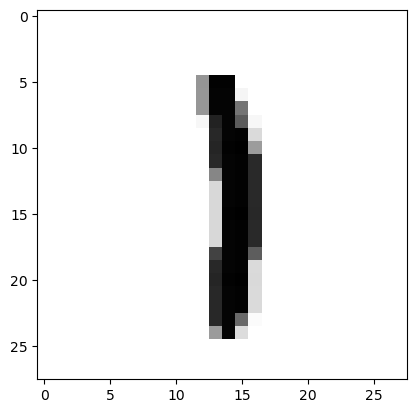

In [28]:
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vector, DenseVector, SparseVector
plt.imshow(DenseVector(val_pred.first().features.toArray()).reshape(28,28),cmap="Greys")

In [39]:
user_labels = model.stages[0].labels
print(user_labels)
from pyspark.ml.feature import IndexToString

user_id_to_label = IndexToString(
    inputCol="prediction", outputCol="prediction_label", labels=user_labels)
pred_label =user_id_to_label.transform(val_pred).select("label","features","prediction_label")
pred_label.show(2)

['1', '7', '3', '9', '2', '6', '0', '4', '8', '5']
+-----+--------------------+----------------+
|label|            features|prediction_label|
+-----+--------------------+----------------+
|    1|(784,[152,153,154...|               1|
|    1|(784,[125,126,127...|               1|
+-----+--------------------+----------------+
only showing top 2 rows



In [44]:
pred_label.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction_label: string (nullable = true)



In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pred_label.select("prediction_label").collect(),pred_label.select(col("label").cast(StringType())).collect())

array([[329,   0,   5,   3,   0,  10,  11,  13,   1,   3],
       [  0, 362,  15,   1,   4,   7,   0,   8,  10,   1],
       [ 11,  25, 307,  48,  22,   8,  27,  15,  37,  13],
       [  5,   0,   7, 185,   1,  19,   1,   0,   5,   5],
       [  2,  21,   6,   5, 278,  10,  14,  31,  11,  30],
       [ 36,   6,  17,  74,   9, 209,  21,   6,  21,   9],
       [  6,  12,  22,  11,  33,  34, 300,   0,  25,   5],
       [  2,   3,  13,   6,   3,   4,   1, 325,   4,  42],
       [ 20,  34,  17,  51,  14,  23,  37,   6, 259,   7],
       [  3,   6,   9,  52,  44,  56,   2,  37,  34, 304]])

In [46]:
!rm -rf data